# Hilbert Convolution Curve

## Introduction

The idea for this curve started from the concept of a Hilbert curve as applied to geographical data. I liked the concept of turning a 2d space (latitude, longitude) into a 1-dimensional line, for dimension reduction purposes. The problem I saw was that the line causes the space to (recursively) break into quadrants, and two points which are close together in quadrants 1 and 4 are far apart on the number line. I'm playing around with the idea of applying a convolution to the hilbert matrix such that the resulting values might provide insight into which points are nearby in 2d space, but far apart on the hilbert curve.

So here's the steps:
1. Generate hilbert curve for a matrix
2. Get absolute sum of distances for every point within the radius around a certain point
3. Graph it (and see what happens)

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
from hilbertcurve.hilbertcurve import HilbertCurve

import matplotlib.pyplot as plt

## General Sandboxing

Just playing around with the hilbertcurve library.

In [2]:
p, n = 3, 2

hilbert = HilbertCurve(p, n)

In [3]:
hilbert_array = np.array([[hilbert.distance_from_point([row, col]) for col in range(2**p)] for row in range(2**p)])

In [4]:
print(hilbert_array)

[[ 0  1 14 15 16 19 20 21]
 [ 3  2 13 12 17 18 23 22]
 [ 4  7  8 11 30 29 24 25]
 [ 5  6  9 10 31 28 27 26]
 [58 57 54 53 32 35 36 37]
 [59 56 55 52 33 34 39 38]
 [60 61 50 51 46 45 40 41]
 [63 62 49 48 47 44 43 42]]


## Getting Started

The goals are as follows:
1. Create a normal matrix
2. Create a hilbert matrix, with values representing the distance of the point along the curve
3. Create a convolution kernel such that:

    3a. "True" values of the kernel fall within a specified radius
    3b. Each "True" value within the kernel is the value's absolute distance from the kernel's center (with respect to the hilbert curve)

4. Apply the convolution kernel to each point in the (padded) hilbert matrix
4. Graph the values with respect to the hilbert matrix

The intuitive (and hopeful) result is that large similar convoluted values will be near each other in 2d space, but far apart on the hilbert curve.

In [5]:
# setting values
exponent = 2
dimension = 2
radius = 1

In [6]:
# get normal matrix
norm_mat = np.reshape(np.arange((2**exponent)**dimension), (2**exponent, 2**exponent))

In [7]:
print(norm_mat)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


In [8]:
# get hilbert matrix
    # cannot be zero-indexed (conflicts with convolve_point function below)
hilbert_ = HilbertCurve(exponent, dimension)
hilbert = np.array(
    [
        [
            hilbert_.distance_from_point([row, col])
            for col in range(2**exponent)
        ]
        for row in range(2**exponent)
    ]
) + 1

In [9]:
print(hilbert)

[[ 1  4  5  6]
 [ 2  3  8  7]
 [15 14  9 10]
 [16 13 12 11]]


In [10]:
# circle kernel for convolution
def circle_kernel(r):
    A = np.arange(-r,r+1)**2
    dists = np.sqrt(A[:,None] + A)
    return ((dists-r)<=0).astype(int)

In [11]:
# testing circle_kernel
print(circle_kernel(1))
print(circle_kernel(2))
print(circle_kernel(3))

[[0 1 0]
 [1 1 1]
 [0 1 0]]
[[0 0 1 0 0]
 [0 1 1 1 0]
 [1 1 1 1 1]
 [0 1 1 1 0]
 [0 0 1 0 0]]
[[0 0 0 1 0 0 0]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [1 1 1 1 1 1 1]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [0 0 0 1 0 0 0]]


In [12]:
# pad hilbert curve for testing with r=1 kernel
hilbert_pad = np.pad(hilbert, pad_width=1, constant_values=0)

In [13]:
print(hilbert_pad)

[[ 0  0  0  0  0  0]
 [ 0  1  4  5  6  0]
 [ 0  2  3  8  7  0]
 [ 0 15 14  9 10  0]
 [ 0 16 13 12 11  0]
 [ 0  0  0  0  0  0]]


In [14]:
kernel = circle_kernel(1)

In [15]:
# submatrix for gathering values (to apply to kernel)
def submatrix(matrix, start_row, start_col, size):
    return matrix[start_row:start_row+size, start_col:start_col+size]

In [16]:
print(submatrix(hilbert_pad, 0, 0, 3))

[[0 0 0]
 [0 1 4]
 [0 2 3]]


In [17]:
# testing convolution
sub = submatrix(hilbert_pad, 0, 0, 3)
sub_center = sub[len(sub)//2][len(sub[0])//2]

In [18]:
convolved = np.array(
        [
            [
                # absolute distance * kernel truth
                abs(sub[i][j] - sub_center) * kernel[i][j]
                for j in range(len(sub[0]))
            ] for i in range(len(sub))
        ]
    )

In [19]:
print(convolved)

[[0 1 0]
 [1 0 3]
 [0 1 0]]


In [20]:
np.sum(convolved)

6

In [21]:
# testing for row, col values for convolve_point function
conv_hilbert = np.array([[hilbert_pad[i][j] for j in range(len(hilbert_pad[0][:-2]))] for i in range(len(hilbert_pad[:-2]))])
print(conv_hilbert)

[[ 0  0  0  0]
 [ 0  1  4  5]
 [ 0  2  3  8]
 [ 0 15 14  9]]


In [22]:
# convolve point function
def convolve_point(matrix, row, col, kernel, verbose=False):
    sub = submatrix(matrix, row, col, len(kernel))
    if verbose==True:
        print(sub)
    sub_center = sub[len(sub)//2][len(sub[0])//2]
    if verbose==True:
        print(sub_center)

    convolved = np.array(
        [
            [
                # != 0 ensures convolutions will not include padding
                abs(sub[i][j] - sub_center) * kernel[i][j] if sub[i][j] != 0 else 0
                for j in range(len(sub[0]))
            ] for i in range(len(sub))
        ]
    )
    if verbose==True:
        print(convolved)

    return np.sum(convolved)

In [23]:
# testing convolve_point
convolve_point(hilbert_pad, 1, 0, circle_kernel(1), verbose=True)

[[ 0  1  4]
 [ 0  2  3]
 [ 0 15 14]]
2
[[ 0  1  0]
 [ 0  0  1]
 [ 0 13  0]]


15

In [24]:
# further testing of convolve_point
convolve_point(hilbert_pad, 2, 0, circle_kernel(1), verbose=True)

[[ 0  2  3]
 [ 0 15 14]
 [ 0 16 13]]
15
[[ 0 13  0]
 [ 0  0  1]
 [ 0  1  0]]


15

In [25]:
# final convolved values
conv_hilb = np.array([[convolve_point(hilbert_pad, i, j, circle_kernel(1)) for j in range(len(hilbert_pad[0][:-2]))] for i in range(len(hilbert_pad[:-2]))])

In [26]:
print(conv_hilb)

[[ 4  5  5  2]
 [15 18 10  5]
 [15 18 10  5]
 [ 4  5  5  2]]


The following code maps the convolved values to the hilbert curve and prepares them for plotting.

In [27]:
conv_flat = conv_hilb.flatten(order='C')

In [28]:
hil_flat = hilbert.flatten(order='C')

In [29]:
k = list(zip(hil_flat, conv_flat))

In [30]:
k

[(1, 4),
 (4, 5),
 (5, 5),
 (6, 2),
 (2, 15),
 (3, 18),
 (8, 10),
 (7, 5),
 (15, 15),
 (14, 18),
 (9, 10),
 (10, 5),
 (16, 4),
 (13, 5),
 (12, 5),
 (11, 2)]

In [31]:
k_sort = sorted(k, key = lambda x: x[0])

In [32]:
print(str(k_sort))

[(1, 4), (2, 15), (3, 18), (4, 5), (5, 5), (6, 2), (7, 5), (8, 10), (9, 10), (10, 5), (11, 2), (12, 5), (13, 5), (14, 18), (15, 15), (16, 4)]


In [33]:
x = [i[0] for i in k_sort]
y = [i[1] for i in k_sort]
print(x)
print(y)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[4, 15, 18, 5, 5, 2, 5, 10, 10, 5, 2, 5, 5, 18, 15, 4]


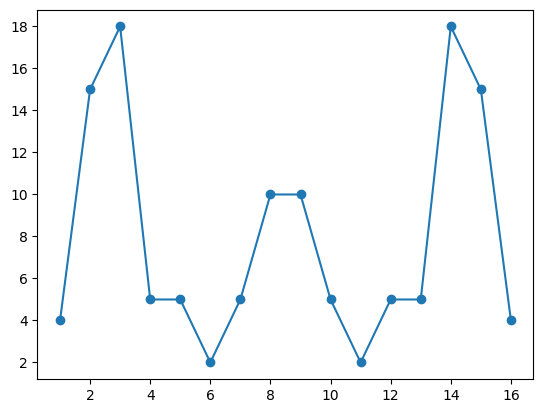

In [34]:
plt.plot(x, y)
plt.scatter(x, y)

Success! The curve has some interesting properties, but it's unclear exactly what it shows.

## Bringing It All Together

Let's clean up our code and combine it into functions for easier use.

In [35]:
def circle_kernel(r):
    A = np.arange(-r,r+1)**2
    dists = np.sqrt(A[:,None] + A)
    return ((dists-r)<=0).astype(int)

In [36]:
def hilbert(exponent):
    hilbert_ = HilbertCurve(exponent, 2)
    return np.array(
        [
            [
                hilbert_.distance_from_point([row, col])
                for col in range(2**exponent)
            ]
            for row in range(2**exponent)
        ]
    ) + 1

In [37]:
def submatrix(matrix, start_row, start_col, size):
    return matrix[start_row:start_row+size, start_col:start_col+size]

In [38]:
def convolve_point(matrix, row, col, kernel, verbose=False):
    sub = submatrix(matrix, row, col, len(kernel))
    if verbose==True:
        print(sub)
    sub_center = sub[len(sub)//2][len(sub[0])//2]
    if verbose==True:
        print(sub_center)

    convolved = np.array(
        [
            [
                abs(sub[i][j] - sub_center) * kernel[i][j] if sub[i][j] != 0 else 0
                for j in range(len(sub[0]))
            ] for i in range(len(sub))
        ]
    )
    if verbose==True:
        print(convolved)

    return np.sum(convolved)

In [39]:
def convolve_hilbert(hilbert, kernel_radius):
    hilbert_pad = np.pad(hilbert, pad_width=kernel_radius, constant_values=0)
    kernel = circle_kernel(kernel_radius)
    return np.array(
        [
            [
                convolve_point(hilbert_pad, i, j, kernel)
            for j in range(len(hilbert_pad[0][:-(kernel_radius*2)]))]
        for i in range(len(hilbert_pad[:-(kernel_radius*2)]))]
    )

In [40]:
h2 = hilbert(2)
r = 1
conv_h2 = convolve_hilbert(h2, r)

In [41]:
print(conv_h2)

[[ 4  5  5  2]
 [15 18 10  5]
 [15 18 10  5]
 [ 4  5  5  2]]


In [42]:
print(h2)

[[ 1  4  5  6]
 [ 2  3  8  7]
 [15 14  9 10]
 [16 13 12 11]]


In [43]:
# prepares hilbert pre- and post-convolution for graphing
def conv_hilb_xy(hilb, conv_hilb):
    hilb_flat = hilb.flatten(order='C')
    conv_hilb_flat = conv_hilb.flatten(order='C')
    z = list(zip(hilb_flat, conv_hilb_flat))
    z_sort = sorted(z, key = lambda x: x[0])
    x = [i[0] for i in z_sort]
    y = [i[1] for i in z_sort]
    return x, y

In [44]:
# testing conv_hilb_xy
x2, y2 = conv_hilb_xy(h2, conv_h2)
print(x2)
print(y2)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[4, 15, 18, 5, 5, 2, 5, 10, 10, 5, 2, 5, 5, 18, 15, 4]


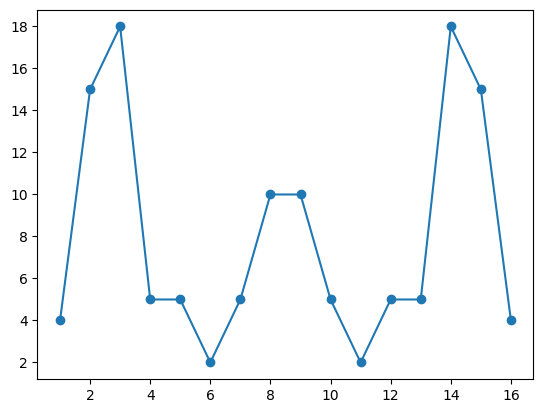

In [45]:
plt.plot(x2, y2)
plt.scatter(x2, y2)

In [46]:
# combines all functions to take only the size (exponent) of matrix and kernel radius
def hilbert_convolution_graph(exponent, radius):
    h = hilbert(exponent)
    ch = convolve_hilbert(h, radius)
    x, y = conv_hilb_xy(h, ch)
    plt.plot(x, y)
    plt.scatter(x, y);

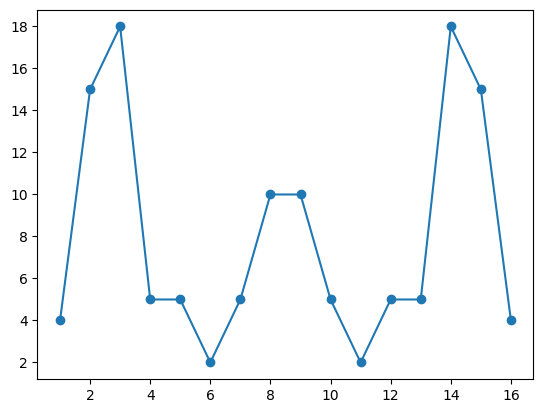

In [47]:
hilbert_convolution_graph(2, 1)

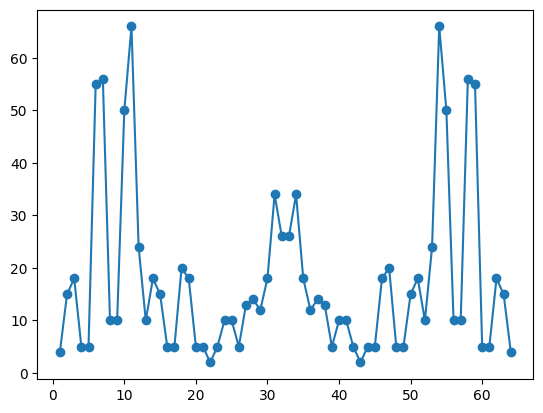

In [48]:
hilbert_convolution_graph(3, 1)

In [49]:
hilbert(3)

array([[ 1,  2, 15, 16, 17, 20, 21, 22],
       [ 4,  3, 14, 13, 18, 19, 24, 23],
       [ 5,  8,  9, 12, 31, 30, 25, 26],
       [ 6,  7, 10, 11, 32, 29, 28, 27],
       [59, 58, 55, 54, 33, 36, 37, 38],
       [60, 57, 56, 53, 34, 35, 40, 39],
       [61, 62, 51, 52, 47, 46, 41, 42],
       [64, 63, 50, 49, 48, 45, 44, 43]])

In [50]:
convolve_hilbert(hilbert(3), 1)

array([[ 4, 15, 15,  5,  5,  5,  5,  2],
       [ 5, 18, 18, 10, 20, 18, 10,  5],
       [ 5, 10, 10, 24, 34, 18, 10,  5],
       [55, 56, 50, 66, 26, 12, 14, 13],
       [55, 56, 50, 66, 26, 12, 14, 13],
       [ 5, 10, 10, 24, 34, 18, 10,  5],
       [ 5, 18, 18, 10, 20, 18, 10,  5],
       [ 4, 15, 15,  5,  5,  5,  5,  2]])

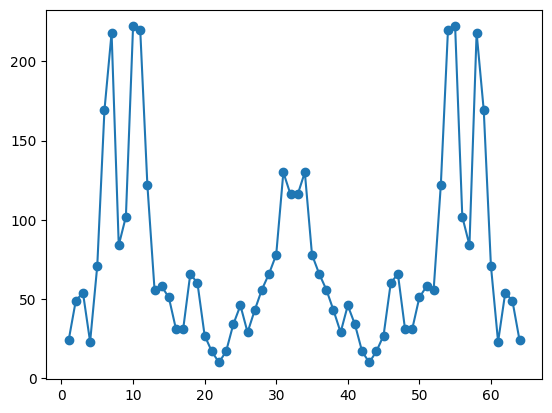

In [51]:
hilbert_convolution_graph(3, 2)

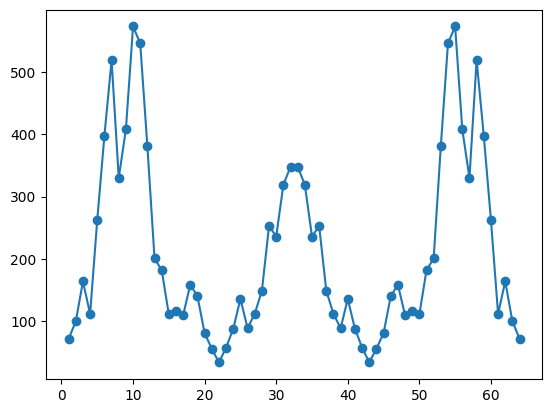

In [52]:
hilbert_convolution_graph(3, 3)

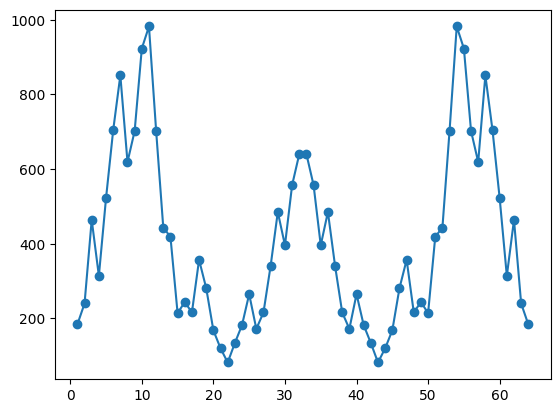

In [53]:
hilbert_convolution_graph(3, 4)

It's not everything I had hoped, but the graph still provides some useful information. The convolution is fractal in nature (representative of the fractal nature of the hilbert curve) but it doesn't necessarily link nearby points together.

A more realistic explanation for such a graph is that the convolution values represent, in aggregate, how distant nearby points are along the hilbert curve.

It's also worth noting that as the kernel radius increases, the graph "smooths out." This makes sense, as each value in the graph is taking more distances into account.

Something interesting is happening in the central 4 points of the 2d matrix. Convoluted values in quadrants 1 and 4 are quite high, but those in 3 and 4 are not so strongly affected. This is probably because our r=1 kernel does not include corner values. The convolutions of central values in quadrants 1 and 3 are not including each other, and the same for those in 2 and 4. Let's change that.

Let's have our r=1 kernel include corner values. This will also affect the rest of the values, particularly those along the boundary of quadrants 1 and 4, but hopefully this will add more "weight" to those central values.

## Convolution with square kernel

In [54]:
# get hilbert matrix
def hilbert(exponent):
    hilbert_ = HilbertCurve(exponent, 2)
    return np.array(
        [
            [
                hilbert_.distance_from_point([row, col])
                for col in range(2**exponent)
            ]
            for row in range(2**exponent)
        ]
    ) + 1

In [55]:
def submatrix(matrix, start_row, start_col, size):
    return matrix[start_row:start_row+size, start_col:start_col+size]

In [56]:
# convolve_point without kernel (all values in submatrix are "true"), r=1 kernel by default
def convolve_point(matrix, row, col, verbose=False):
    sub = submatrix(matrix, row, col, 3)
    if verbose==True:
        print(sub)
    sub_center = sub[len(sub)//2][len(sub[0])//2]
    if verbose==True:
        print(sub_center)

    convolved = np.array(
        [
            [
                abs(sub[i][j] - sub_center) if sub[i][j] != 0 else 0
                for j in range(len(sub[0]))
            ] for i in range(len(sub))
        ]
    )
    if verbose==True:
        print(convolved)

    return np.sum(convolved)

In [57]:
def convolve_hilbert(hilbert):
    hilbert_pad = np.pad(hilbert, pad_width=1, constant_values=0)
    return np.array(
        [
            [
                convolve_point(hilbert_pad, i, j)
            for j in range(len(hilbert_pad[0][:-2]))]
        for i in range(len(hilbert_pad[:-2]))]
    )

In [58]:
def conv_hilb_xy(hilb, conv_hilb):
    hilb_flat = hilb.flatten(order='C')
    conv_hilb_flat = conv_hilb.flatten(order='C')
    z = list(zip(hilb_flat, conv_hilb_flat))
    z_sort = sorted(z, key = lambda x: x[0])
    x = [i[0] for i in z_sort]
    y = [i[1] for i in z_sort]
    return x, y

In [59]:
def hilbert_convolution_graph(exponent):
    h = hilbert(exponent)
    ch = convolve_hilbert(h)
    x, y = conv_hilb_xy(h, ch)

    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.scatter(x, y)

In [60]:
hilbert(2)

array([[ 1,  4,  5,  6],
       [ 2,  3,  8,  7],
       [15, 14,  9, 10],
       [16, 13, 12, 11]])

In [61]:
convolve_hilbert(hilbert(2))

array([[ 6, 11,  9,  4],
       [29, 40, 24,  9],
       [29, 40, 24,  9],
       [ 6, 11,  9,  4]])

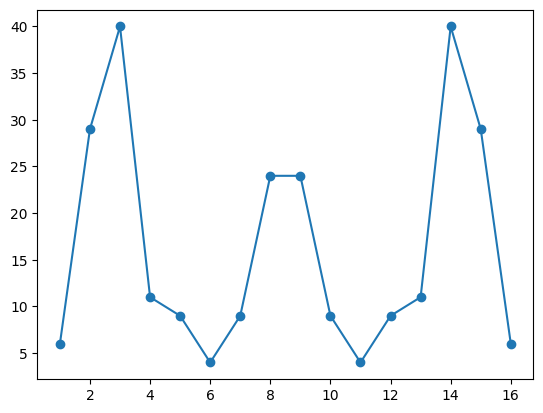

In [62]:
hilbert_convolution_graph(2)

In [63]:
hilbert(3)

array([[ 1,  2, 15, 16, 17, 20, 21, 22],
       [ 4,  3, 14, 13, 18, 19, 24, 23],
       [ 5,  8,  9, 12, 31, 30, 25, 26],
       [ 6,  7, 10, 11, 32, 29, 28, 27],
       [59, 58, 55, 54, 33, 36, 37, 38],
       [60, 57, 56, 53, 34, 35, 40, 39],
       [61, 62, 51, 52, 47, 46, 41, 42],
       [64, 63, 50, 49, 48, 45, 44, 43]])

In [64]:
convolve_hilbert(hilbert(3))

array([[  6,  29,  29,   9,  11,  11,   9,   4],
       [ 11,  40,  40,  38,  42,  40,  24,   9],
       [  9,  24,  24,  54,  86,  40,  24,   9],
       [109, 160, 146, 154,  74,  30,  36,  25],
       [109, 160, 146, 154,  74,  30,  36,  25],
       [  9,  24,  24,  54,  86,  40,  24,   9],
       [ 11,  40,  40,  38,  42,  40,  24,   9],
       [  6,  29,  29,   9,  11,  11,   9,   4]])

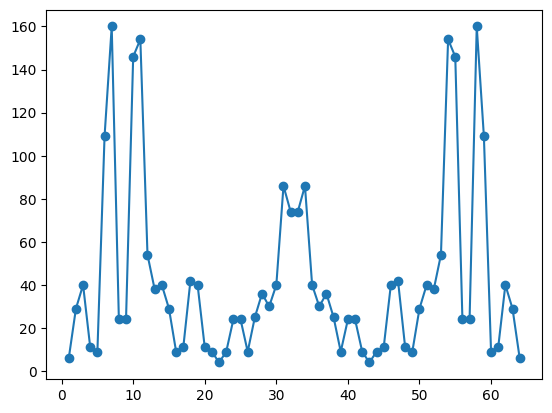

In [65]:
hilbert_convolution_graph(3)

## Circular Convolution by Quadrant Size

I'd like to "level out" the convolution curve so the similarity of points are better defined. To respect the geometry, I will create a circular convolution with a radius equal to the size of the largest quadrant.

In [3]:
def circle_kernel(r):
    A = np.arange(-r,r+1)**2
    dists = np.sqrt(A[:,None] + A)
    return ((dists-r)<=0).astype(int)

In [4]:
def hilbert(exponent):
    hilbert_ = HilbertCurve(exponent, 2)
    return np.array(
        [
            [
                hilbert_.distance_from_point([row, col])
                for col in range(2**exponent)
            ]
            for row in range(2**exponent)
        ]
    ) + 1

In [5]:
def submatrix(matrix, start_row, start_col, size):
    return matrix[start_row:start_row+size, start_col:start_col+size]

In [6]:
def convolve_point(matrix, row, col, kernel, verbose=False):
    sub = submatrix(matrix, row, col, len(kernel))
    if verbose==True:
        print(sub)
    sub_center = sub[len(sub)//2][len(sub[0])//2]
    if verbose==True:
        print(sub_center)

    convolved = np.array(
        [
            [
                abs(sub[i][j] - sub_center) * kernel[i][j] if sub[i][j] != 0 else 0
                for j in range(len(sub[0]))
            ] for i in range(len(sub))
        ]
    )
    if verbose==True:
        print(convolved)

    return np.sum(convolved)

In [7]:
def convolve_hilbert(hilbert, kernel_radius):
    hilbert_pad = np.pad(hilbert, pad_width=kernel_radius, constant_values=0)
    kernel = circle_kernel(kernel_radius)
    return np.array(
        [
            [
                convolve_point(hilbert_pad, i, j, kernel)
            for j in range(len(hilbert_pad[0][:-(kernel_radius*2)]))]
        for i in range(len(hilbert_pad[:-(kernel_radius*2)]))]
    )

In [8]:
# prepares hilbert pre- and post-convolution for graphing
def conv_hilb_xy(hilb, conv_hilb):
    hilb_flat = hilb.flatten(order='C')
    conv_hilb_flat = conv_hilb.flatten(order='C')
    z = list(zip(hilb_flat, conv_hilb_flat))
    z_sort = sorted(z, key = lambda x: x[0])
    x = [i[0] for i in z_sort]
    y = [i[1] for i in z_sort]
    return x, y

In [9]:
# combines all functions to take only the size (exponent) of matrix and kernel radius
def hilbert_convolution_graph(exponent, radius):
    h = hilbert(exponent)
    ch = convolve_hilbert(h, radius)
    x, y = conv_hilb_xy(h, ch)
    plt.plot(x, y)
    plt.scatter(x, y);

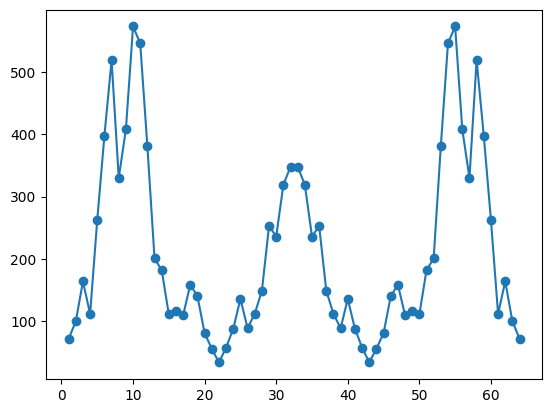

In [10]:
hilbert_convolution_graph(3, 3)

In [11]:
hilbert(3)

array([[ 1,  2, 15, 16, 17, 20, 21, 22],
       [ 4,  3, 14, 13, 18, 19, 24, 23],
       [ 5,  8,  9, 12, 31, 30, 25, 26],
       [ 6,  7, 10, 11, 32, 29, 28, 27],
       [59, 58, 55, 54, 33, 36, 37, 38],
       [60, 57, 56, 53, 34, 35, 40, 39],
       [61, 62, 51, 52, 47, 46, 41, 42],
       [64, 63, 50, 49, 48, 45, 44, 43]])

In [12]:
convolve_hilbert(hilbert(3), 3)

array([[ 72, 100, 111, 116, 110,  81,  56,  34],
       [112, 164, 182, 201, 159, 140,  88,  58],
       [263, 330, 408, 381, 319, 236, 136,  89],
       [398, 519, 573, 546, 348, 253, 149, 112],
       [398, 519, 573, 546, 348, 253, 149, 112],
       [263, 330, 408, 381, 319, 236, 136,  89],
       [112, 164, 182, 201, 159, 140,  88,  58],
       [ 72, 100, 111, 116, 110,  81,  56,  34]])

Why are the corner calculations different (for above, 72 vs 34)? Wouldn't they all be the same if their convolutions don't include values from other quadrants?

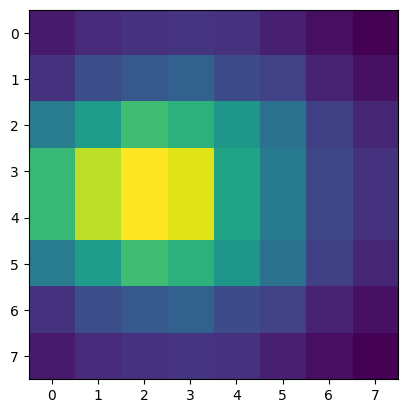

In [13]:
plt.imshow(convolve_hilbert(hilbert(3), 3))

I'll have to investigate this later. For the moment, I'd like to get some lines that fit nearby points.

## Fitting Lines

In [14]:
# hilbert and convolved hilbert
h3 = hilbert(3)
ch3 = convolve_hilbert(h3, 3)

In [15]:
# get hilb / conv_hilb pairs by specifying hilb coordinates in list
def get_points_by_selection(hilb, conv_hilb, point_list):
    x, y = conv_hilb_xy(hilb, conv_hilb)
    x = [point for point in point_list]
    y = [y[point-1] for point in point_list]

    return pd.DataFrame(data={'x': x, 'y': y}, columns=['x', 'y'])

In [16]:
h3df_center = get_points_by_selection(h3, ch3, [11, 32, 33, 54])

In [17]:
poly_2 = np.polyfit(h3df_center['x'], h3df_center['y'], deg=2)

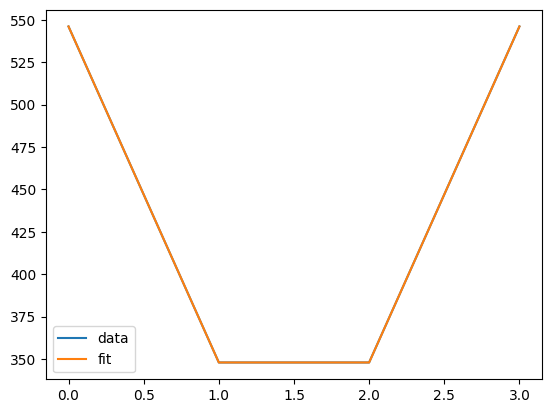

In [18]:
fig, ax = plt.subplots()
ax.plot(h3df_center['y'], label='data')
ax.plot(np.polyval(poly_2, h3df_center['x']), label='fit')
ax.legend()

In [19]:
# hilbert_convolution_graph for use with fig, ax graphing structure
def hilbert_convolution_graph_ax(exponent, radius):
    h = hilbert(exponent)
    ch = convolve_hilbert(h, radius)
    x, y = conv_hilb_xy(h, ch)
    ax.plot(x, y, label='convolution');

In [20]:
# get best fit polynomial line x**3
poly_3 = np.polyfit(h3df_center['x'], h3df_center['y'], deg=3)

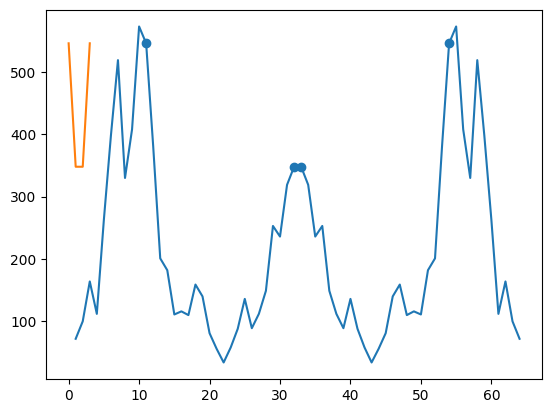

In [21]:
# graph poly_3
fig, ax = plt.subplots()
hilbert_convolution_graph_ax(3, 3)
ax.scatter(h3df_center['x'], h3df_center['y'], label='points')
ax.plot(np.polyval(poly_3, h3df_center['x']), label='fit');

Not exactly what I wanted. I'd like the polynomial to be plotted with respect to the convolution graph.

NumPy documentation states that polyfit is outdated, use Polynomial class instead.

In [23]:
poly_fit_2 = np.polynomial.polynomial.Polynomial.fit(h3df_center['x'], h3df_center['y'], deg=2)

In [24]:
poly_fit_2

Polynomial([3.47892857e+02, 4.01835021e-14, 1.98107143e+02], domain=[11., 54.], window=[-1.,  1.])

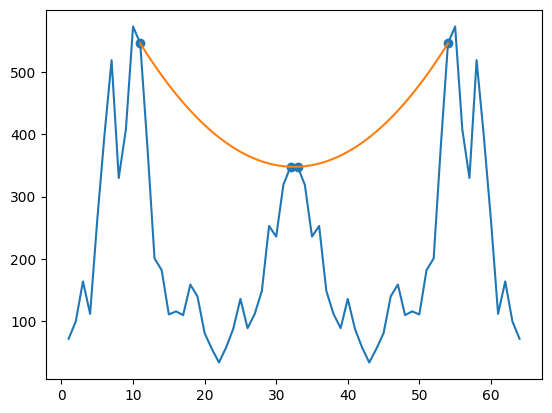

In [27]:
fig, ax = plt.subplots()
hilbert_convolution_graph_ax(3, 3)
ax.scatter(h3df_center['x'], h3df_center['y'], label='points')
poly_x, poly_y = poly_fit_2.linspace(n=100)
ax.plot(poly_x, poly_y, label='fit');

Much better. Now that I have what I want, I'm not sure what to do with it.

## Useful Functions

In [3]:
def circle_kernel(r):
    A = np.arange(-r,r+1)**2
    dists = np.sqrt(A[:,None] + A)
    return ((dists-r)<=0).astype(int)

In [4]:
def submatrix(matrix, start_row, start_col, size):
    return matrix[start_row:start_row+size, start_col:start_col+size]

In [5]:
def hilbert(exponent):
    hilbert_ = HilbertCurve(exponent, 2)
    return np.array(
        [
            [
                hilbert_.distance_from_point([row, col])
                for col in range(2**exponent)
            ]
            for row in range(2**exponent)
        ]
    ) + 1

In [6]:
def convolve_point(matrix, row, col, kernel, verbose=False):
    sub = submatrix(matrix, row, col, len(kernel))
    if verbose==True:
        print(sub)
    sub_center = sub[len(sub)//2][len(sub[0])//2]
    if verbose==True:
        print(sub_center)

    convolved = np.array(
        [
            [
                abs(sub[i][j] - sub_center) * kernel[i][j] if sub[i][j] != 0 else 0
                for j in range(len(sub[0]))
            ] for i in range(len(sub))
        ]
    )
    if verbose==True:
        print(convolved)

    return np.sum(convolved)

In [7]:
def convolve_hilbert(hilbert, kernel_radius):
    hilbert_pad = np.pad(hilbert, pad_width=kernel_radius, constant_values=0)
    kernel = circle_kernel(kernel_radius)
    return np.array(
        [
            [
                convolve_point(hilbert_pad, i, j, kernel)
            for j in range(len(hilbert_pad[0][:-(kernel_radius*2)]))]
        for i in range(len(hilbert_pad[:-(kernel_radius*2)]))]
    )

In [8]:
# prepares hilbert pre- and post-convolution for graphing
def conv_hilb_xy(hilb, conv_hilb):
    hilb_flat = hilb.flatten(order='C')
    conv_hilb_flat = conv_hilb.flatten(order='C')
    z = list(zip(hilb_flat, conv_hilb_flat))
    z_sort = sorted(z, key = lambda x: x[0])
    x = [i[0] for i in z_sort]
    y = [i[1] for i in z_sort]
    return x, y

In [9]:
# combines all functions to take only the size (exponent) of matrix and kernel radius
def hilbert_convolution_graph(exponent, radius):
    h = hilbert(exponent)
    ch = convolve_hilbert(h, radius)
    x, y = conv_hilb_xy(h, ch)
    plt.plot(x, y)
    plt.scatter(x, y);

Unrelated (for now) but I've put together a circle_kernel function that works for higher dimensions.

In [10]:
def hypersphere_kernel(radius: int, dimension: int):
    first_dimension = np.arange(-radius, radius+1)**2
    dimension_iterable = dimension + 1
    high_dimension = first_dimension.copy()
    while dimension > 1:
        matrix_dimensions = ":, " * (dimension_iterable - dimension)
        increase_dimension = eval('high_dimension[' + matrix_dimensions + 'None]')
        high_dimension = increase_dimension + first_dimension
        dimension -= 1
    return ((np.sqrt(high_dimension)-radius)<=0).astype(int)

## Squared and Log Squared Distances

In [11]:
def convolve_point_sqdist(matrix, row, col, kernel, verbose=False):
    sub = submatrix(matrix, row, col, len(kernel))
    if verbose==True:
        print(sub)
    sub_center = sub[len(sub)//2][len(sub[0])//2]
    if verbose==True:
        print(sub_center)

    convolved = np.array(
        [
            [
                (sub[i][j] - sub_center)**2 * kernel[i][j] if sub[i][j] != 0 else 0
                for j in range(len(sub[0]))
            ] for i in range(len(sub))
        ]
    )
    if verbose==True:
        print(convolved)

    return np.sum(convolved)

In [12]:
def convolve_point_sqdist_log(matrix, row, col, kernel, verbose=False):
    sub = submatrix(matrix, row, col, len(kernel))
    if verbose==True:
        print(sub)
    sub_center = sub[len(sub)//2][len(sub[0])//2]
    if verbose==True:
        print(sub_center)

    convolved = np.array(
        [
            [
                np.log((sub[i][j] - sub_center)**2) * kernel[i][j] if (sub[i][j]!=0 and (sub[i][j]-sub_center)!=0) else 0
                for j in range(len(sub[0]))
            ] for i in range(len(sub))
        ]
    )
    if verbose==True:
        print(convolved)

    return np.sum(convolved)

In [13]:
def convolve_hilbert(hilbert, kernel_radius, conv_type='abs'):
    hilbert_pad = np.pad(hilbert, pad_width=kernel_radius, constant_values=0)
    kernel = circle_kernel(kernel_radius)
    if conv_type == 'abs':
        return np.array(
            [
                [
                    convolve_point(hilbert_pad, i, j, kernel)
                for j in range(len(hilbert_pad[0][:-(kernel_radius*2)]))]
            for i in range(len(hilbert_pad[:-(kernel_radius*2)]))]
        )
    elif conv_type == 'sq':
        return np.array(
            [
                [
                    convolve_point_sqdist(hilbert_pad, i, j, kernel)
                for j in range(len(hilbert_pad[0][:-(kernel_radius*2)]))]
            for i in range(len(hilbert_pad[:-(kernel_radius*2)]))]
        )
    elif conv_type == 'log':
        return np.array(
            [
                [
                    convolve_point_sqdist_log(hilbert_pad, i, j, kernel)
                for j in range(len(hilbert_pad[0][:-(kernel_radius*2)]))]
            for i in range(len(hilbert_pad[:-(kernel_radius*2)]))]
        )

In [14]:
# combines all functions to take only the size (exponent) of matrix and kernel radius
def hilbert_convolution_graph(exponent, radius, conv_type):
    h = hilbert(exponent)
    ch = convolve_hilbert(h, radius, conv_type)
    x, y = conv_hilb_xy(h, ch)
    plt.plot(x, y)
    plt.scatter(x, y);

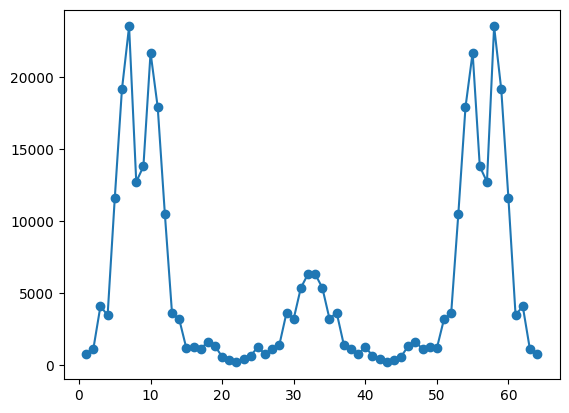

In [15]:
hilbert_convolution_graph(3, 3, 'sq')

In [16]:
hilbert(3)

array([[ 1,  2, 15, 16, 17, 20, 21, 22],
       [ 4,  3, 14, 13, 18, 19, 24, 23],
       [ 5,  8,  9, 12, 31, 30, 25, 26],
       [ 6,  7, 10, 11, 32, 29, 28, 27],
       [59, 58, 55, 54, 33, 36, 37, 38],
       [60, 57, 56, 53, 34, 35, 40, 39],
       [61, 62, 51, 52, 47, 46, 41, 42],
       [64, 63, 50, 49, 48, 45, 44, 43]])

In [17]:
convolve_hilbert(hilbert(3), 3, conv_type='sq')

array([[  758,  1080,  1149,  1234,  1102,   561,   340,   158],
       [ 3432,  4074,  3168,  3565,  1589,  1296,   634,   420],
       [11565, 12700, 13770, 10459,  5343,  3194,  1236,   729],
       [19114, 23489, 21671, 17880,  6296,  3619,  1393,  1062],
       [19114, 23489, 21671, 17880,  6296,  3619,  1393,  1062],
       [11565, 12700, 13770, 10459,  5343,  3194,  1236,   729],
       [ 3432,  4074,  3168,  3565,  1589,  1296,   634,   420],
       [  758,  1080,  1149,  1234,  1102,   561,   340,   158]])

In [18]:
convolve_hilbert(hilbert(3), 3, conv_type='log')

array([[ 33.44980064,  44.47262181,  51.40409361,  53.71899919,
         52.59976761,  44.57959918,  32.04140661,  20.53626133],
       [ 38.55209762,  59.92138884,  73.55362553,  79.10839532,
         75.49237717,  69.20737148,  48.18521779,  32.04140661],
       [ 60.57979509,  83.35943283, 110.28967622, 114.66035928,
        114.90043997,  98.60026015,  67.85991329,  46.12597895],
       [ 75.84330493, 103.49211338, 130.41020836, 136.21462079,
        120.13894937, 103.30003961,  73.23717752,  54.00636672],
       [ 75.84330493, 103.49211338, 130.41020836, 136.21462079,
        120.13894937, 103.30003961,  73.23717752,  54.00636672],
       [ 60.57979509,  83.35943283, 110.28967622, 114.66035928,
        114.90043997,  98.60026015,  67.85991329,  46.12597895],
       [ 38.55209762,  59.92138884,  73.55362553,  79.10839532,
         75.49237717,  69.20737148,  48.18521779,  32.04140661],
       [ 33.44980064,  44.47262181,  51.40409361,  53.71899919,
         52.59976761,  44.5795991

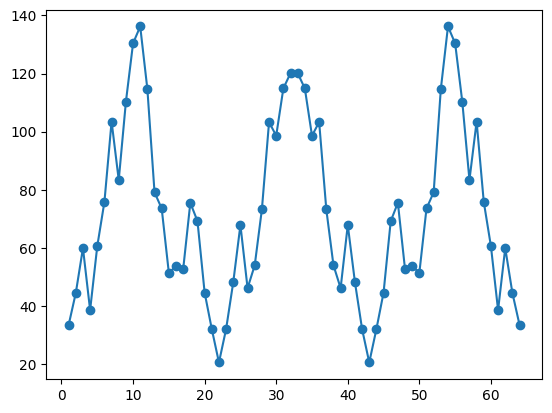

In [19]:
hilbert_convolution_graph(3, 3, 'log')

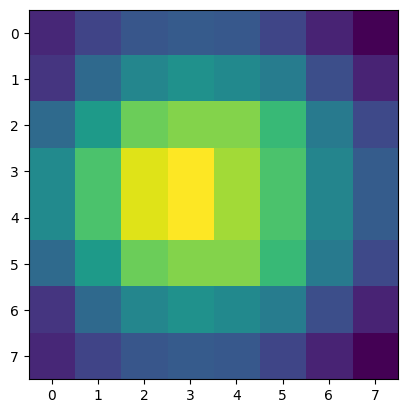

In [20]:
plt.imshow(convolve_hilbert(hilbert(3), 3, conv_type='log'));

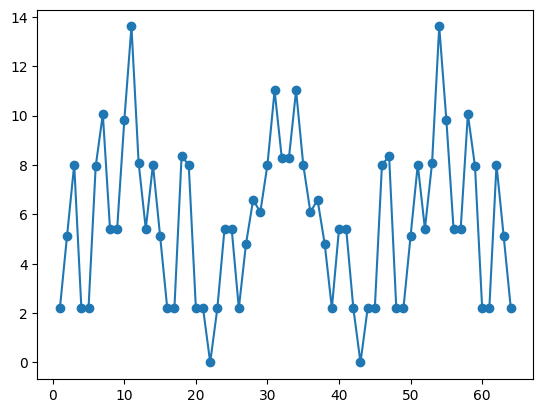

In [21]:
hilbert_convolution_graph(3, 1, conv_type='log')

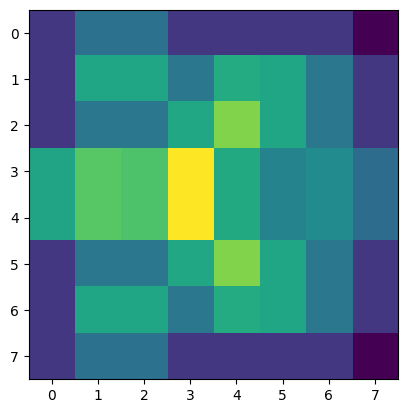

In [22]:
plt.imshow(convolve_hilbert(hilbert(3), 1, conv_type='log'));

In [23]:
hilbert(3)

array([[ 1,  2, 15, 16, 17, 20, 21, 22],
       [ 4,  3, 14, 13, 18, 19, 24, 23],
       [ 5,  8,  9, 12, 31, 30, 25, 26],
       [ 6,  7, 10, 11, 32, 29, 28, 27],
       [59, 58, 55, 54, 33, 36, 37, 38],
       [60, 57, 56, 53, 34, 35, 40, 39],
       [61, 62, 51, 52, 47, 46, 41, 42],
       [64, 63, 50, 49, 48, 45, 44, 43]])

This is a much more interesting heatmap than the one with a wider radius; it appears to display more about the shape of the hilbert curve.